In [1]:
#modify codes from https://acadgild.com/blog/random-forest-algorithm-regression
#
import numpy as np
import pandas as pd

#import pyreadr #read .Rda file
#import pyreadstat #read stata

#one hot encoding
from sklearn.preprocessing import LabelBinarizer

#plot
%matplotlib inline
import matplotlib.pyplot as plt
from plotnine import *

#evaluate model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

#explain shapley values
import shap

#random forest regression
from sklearn.ensemble import RandomForestRegressor

#PCA
from sklearn.decomposition import PCA

#TSNE
from sklearn import (manifold,datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)
from sklearn.manifold import TSNE

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
#data from standfirm
#Framingham risk score 10-year risk in %: 
#Points total: 0 point: <1%. 1-4 points: 1%. 5-6 points: 2%. 7 points: 3%. 8 points: 4%. 9 points: 5%. 10 points: 6%. 11 points: 8%. 12 points: 10%. 13 points: 12%. 14 points: 16%. 15 points: 20%. 16 points: 25%. 17 points or more: Over 30%.[17]
#This dataset uses imputed data from goal1.dta
dftrain=pd.read_csv('.././Ext-Data/newdat.train.180520.csv',index_col=0) #remove unnamed column 0
dftest=pd.read_csv('.././Ext-Data/newdat.test.180520.csv',index_col=0)
dftrain.head()

,Outcome,base_dep,base_anx,Marital_Status,LivStat,COB,FluEng,HighEd,SocClass,Male1,...,base_Height,base_Weight,base_HbA1c,base_Glu,base_SodExcr,base_PotExcr,base_Veg_serves31,base_Add_salt_33a,base_rfi1,SodPotExcr
316,28.11,5,3.0,5,3,200,1.0,3,4.0,0,...,151.0,64.6,7.3,8.3,75.0,55.0,2.0,2,28.427977,1.363636
453,26.02,1,1.0,5,1,17,1.0,4,2.0,1,...,162.7,67.3,5.8,5.5,207.0,87.0,3.0,2,25.822906,2.379310
161,24.69,3,0.0,2,1,200,1.0,5,3.0,1,...,174.0,69.2,5.5,3.9,85.0,79.0,2.0,1,24.547840,1.075949
325,23.83,2,8.0,2,1,200,1.0,6,1.0,1,...,181.0,70.6,5.7,5.5,153.0,93.0,2.0,2,23.993385,1.645161
123,25.33,1,2.0,2,1,200,1.0,3,4.0,1,...,161.0,76.3,6.3,4.8,133.0,91.0,1.0,2,25.521479,1.461538


In [3]:
#if Female is 2 change to 0
dftrain["Male1"].loc[(dftrain["Male1"] == 2) ] = 0
dftest["Male1"].loc[(dftest["Male1"] == 2) ] = 0

#change column names
dftrain.rename(columns={'base_age':'age','Male1':'Male','base_HbA1c':'HbA1c','HighEd':'HigherEducation',                        'SocClass':'SocialClass',
                        'base_chol':'Cholesterol',
                        'base_Glu':'serumglucose',
                        'base_meanDBP':'meanDiastolicBloodPressure',
                        'base_CreatExcr':'CreatinineExceretion',
                        'base_lhs':'LondonHandicapScore',
                        'SodbyPot':'SodiumPotassiumratio',
                        'base_salt_calc':'Saltintake',
                        'base_Ev_smoke1':'EverSmoker',
                        'base_SodExcr':'UrinarySodiumExcretion',
                        'base_PotExcr':'UrinaryPotassiumExcretion',
                        'base_Veg_serves31':'Vegetable'})
 #list(dftrain)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Outcome,base_dep,base_anx,Marital_Status,LivStat,COB,FluEng,HigherEducation,SocialClass,Male,...,base_Height,base_Weight,HbA1c,serumglucose,UrinarySodiumExcretion,UrinaryPotassiumExcretion,Vegetable,base_Add_salt_33a,base_rfi1,SodPotExcr
316,28.11,5,3.0,5,3,200,1.0,3,4.0,0,...,151.0,64.6,7.3,8.3,75.0,55.0,2.0,2,28.427977,1.363636
453,26.02,1,1.0,5,1,17,1.0,4,2.0,1,...,162.7,67.3,5.8,5.5,207.0,87.0,3.0,2,25.822906,2.379310
161,24.69,3,0.0,2,1,200,1.0,5,3.0,1,...,174.0,69.2,5.5,3.9,85.0,79.0,2.0,1,24.547840,1.075949
325,23.83,2,8.0,2,1,200,1.0,6,1.0,1,...,181.0,70.6,5.7,5.5,153.0,93.0,2.0,2,23.993385,1.645161
123,25.33,1,2.0,2,1,200,1.0,3,4.0,1,...,161.0,76.3,6.3,4.8,133.0,91.0,1.0,2,25.521479,1.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,23.49,4,3.0,1,1,200,1.0,3,3.0,1,...,167.2,89.8,6.2,5.5,174.0,101.0,1.0,1,23.397905,1.722772
508,27.63,6,3.0,2,2,200,1.0,3,5.0,0,...,157.4,84.7,6.2,6.4,76.0,30.0,3.0,1,27.953178,2.533333
432,25.10,8,0.0,5,1,22,1.0,4,1.0,1,...,173.0,81.6,5.8,4.6,128.0,66.0,2.0,1,25.382383,1.939394
118,24.21,6,5.0,2,1,200,1.0,7,2.0,1,...,176.5,88.6,5.6,4.7,168.0,60.0,2.0,1,23.712095,2.800000


In [4]:
dftest.rename(columns={'base_age':'age',
                        'Male1':'Male',
                        'base_HbA1c':'HbA1c',
                        'HighEd':'HigherEducation',
                        'SocClass':'SocialClass',
                        'base_chol':'Cholesterol',
                        'base_Glu':'serumglucose',
                        'base_meanDBP':'meanDiastolicBloodPressure',
                        'base_CreatExcr':'CreatinineExceretion',
                        'base_lhs':'LondonHandicapScore',
                        'SodbyPot':'SodiumPotassiumratio',
                        'base_salt_calc':'Saltintake',
                        'base_Ev_smoke1':'EverSmoker',
                        'base_SodExcr':'UrinarySodiumExcretion',
                        'base_PotExcr':'UrinaryPotassiumExcretion',
                        'base_Veg_serves31':'Vegetable'})                  
#list(dftest)

,Outcome,base_dep,base_anx,Marital_Status,LivStat,COB,FluEng,HigherEducation,SocialClass,Male,...,base_Height,base_Weight,HbA1c,serumglucose,UrinarySodiumExcretion,UrinaryPotassiumExcretion,Vegetable,base_Add_salt_33a,base_rfi1,SodPotExcr
482,26.89,4.0,0.0,2,1,16,1.006736,1,4.0,0,...,164.0,70.0,6.2,5.0,139.0,118,3.0,1,27.402065,1.177966
444,25.19,4.0,8.0,2,1,200,1.000000,2,4.0,1,...,181.0,98.0,7.2,6.9,168.0,75,5.0,2,25.944654,2.240000
22,25.21,1.0,4.0,2,1,200,1.000000,5,2.0,1,...,168.1,63.0,5.5,4.6,108.0,42,1.0,1,25.736155,2.571429
276,25.22,2.0,3.0,2,1,200,1.000000,2,3.0,1,...,174.5,108.3,5.5,4.6,268.0,89,3.0,1,25.360676,3.011236
33,24.31,2.0,4.0,2,1,200,1.000000,5,3.0,1,...,179.0,87.0,6.0,5.9,192.0,99,0.4,1,24.775389,1.939394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,25.36,3.0,2.0,2,1,17,1.000000,2,4.0,1,...,182.0,89.4,5.9,5.0,292.0,69,3.0,1,24.993473,4.231884
190,24.46,5.0,3.0,2,1,1,1.000000,6,2.0,1,...,175.8,79.9,6.3,11.4,150.0,106,2.5,2,24.526068,1.415094
197,25.30,2.0,7.0,2,1,31,1.000000,6,4.0,1,...,173.4,86.8,5.9,5.2,328.0,68,0.5,2,23.801186,4.823529
435,23.91,5.0,8.0,2,2,200,1.000000,5,2.0,1,...,179.0,88.9,5.6,7.3,178.0,52,5.0,2,24.398449,3.423077


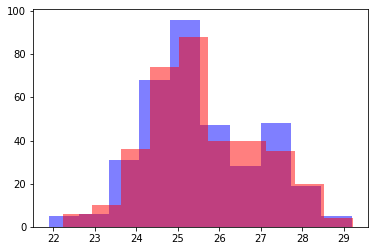

In [5]:
#hisogram plot of framingham risk score
num_bins = 10
n, bins, patches = plt.hist(dftrain['base_rfi1'], num_bins, facecolor='blue', alpha=0.5)
plt.show

num_bins = 10
n, bins, patches = plt.hist(dftrain['Outcome'], num_bins, facecolor='red', alpha=0.5)
plt.show

#iloc integer location
#X = df.iloc[:,:-1] #row by column, select all columns except remove last column
#y = df.iloc[:,-2] #or y = df['SodbyPot'] second last column

#create new columns train
dftrain['changefrs12m'] = (dftrain['base_rfi1']-dftrain['Outcome'])/dftrain['Outcome']
dftrain['rawchangefrs12m'] = (dftrain['base_rfi1']-dftrain['Outcome'])
#create new columns test
dftest['changefrs12m'] = (dftest['base_rfi1']-dftest['Outcome'])/dftest['Outcome']
dftest['rawchangefrs12m'] = (dftest['base_rfi1']-dftest['Outcome'])
##################
#test changefrs12m
#poor results
##################

#drop train
#x_training_set = dftrain.drop(['base_frs1','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
#y_training_set = dftrain['changefrs12m']
#drop test
#x_test_set = dftest.drop(['base_frs1','_12m_frs1','changefrs12m'],axis=1) #axis=1 refers to column
#y_test_set = dftest['changefrs12m']


###########################
#test prediction of frs 12m
###########################
#drop train
x_training_set = dftrain.drop(['rawchangefrs12m','base_rfi1','Outcome','changefrs12m'],axis=1) #axis=1 refers to column
y_training_set = dftrain['Outcome']

x_training2_set = dftrain.drop(['rawchangefrs12m','Outcome','changefrs12m'],axis=1) #axis=1 refers to column
y_training2_set=dftrain['changefrs12m'] #keep baseline frs

x_training3_set = dftrain.drop(['rawchangefrs12m','Outcome','changefrs12m'],axis=1) #axis=1 refers to column
y_training3_set=dftrain['rawchangefrs12m'] #keep baseline frs

#drop test
x_test_set = dftest.drop(['rawchangefrs12m','base_rfi1','Outcome','changefrs12m'],axis=1) #axis=1 refers to column
y_test_set = dftest['Outcome']

x_test2_set = dftest.drop(['rawchangefrs12m','Outcome','changefrs12m'],axis=1) #axis=1 refers to column
y_test2_set= dftest['changefrs12m']

x_test3_set = dftest.drop(['rawchangefrs12m','Outcome','changefrs12m'],axis=1) #axis=1 refers to column
y_test3_set= dftest['rawchangefrs12m']

In [6]:
list(dftrain)

['Outcome',
 'base_dep',
 'base_anx',
 'Marital_Status',
 'LivStat',
 'COB',
 'FluEng',
 'HighEd',
 'SocClass',
 'Male1',
 'base_age',
 'base_AlcUse',
 'base_HDLChol',
 'base_LDLChol',
 'base_Creat',
 'DiabHist38a',
 'CholHist38c',
 'StrokeHist',
 'IHDHist38d',
 'HFHist38e',
 'AFHist38f',
 'RheumHist38g',
 'PaceHist38h',
 'CarotStenHist',
 'base_Ev_smoke1',
 'base_bmi',
 'base_proteinuria',
 'base_meanSBP',
 'base_meanDBP',
 'base_cons_5vegs',
 'base_risk_salt',
 'base_anx_class',
 'base_Height',
 'base_Weight',
 'base_HbA1c',
 'base_Glu',
 'base_SodExcr',
 'base_PotExcr',
 'base_Veg_serves31',
 'base_Add_salt_33a',
 'base_rfi1',
 'SodPotExcr',
 'changefrs12m',
 'rawchangefrs12m']

In [7]:
#https://www.datacamp.com/community/tutorials/categorical-data
#lb = LabelBinarizer()
#lb_results = lb.fit_transform(dftrain['Male1'])
#lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
#lb_results
#dftrain['Malebin'] = lb_make.fit_transform(dftrain['Male1'])
#dftest['Male1bin'] = lb_make.fit_transform(dftest['Male1'])

In [8]:
#Identify the predictor variables and encode any string variables to equivalent integer codes 
#dftrain['Marital_Status'],_ = pd.factorize(dftrain['Marital_Status'])
#dftrain['LivStat'],_ = pd.factorize(dftrain['LivStat'])
#dftrain['FluEng'],_ = pd.factorize(dftrain['FluEng'])
#dftrain['HighEd'],_ = pd.factorize(dftrain['HighEd'])
#dftrain['SocClass'],_ = pd.factorize(dftrain['SocClass'])

In [9]:
#first model 12 month frs
n_estimators=200
# Fit regression model
# Estimate the score on the entire dataset, with no missing values
model = RandomForestRegressor(random_state=0, n_estimators=n_estimators)
model.fit(x_training_set, y_training_set)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [10]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(x_training_set, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))


name                     score
Male1              0.599319
base_age           0.255756
base_LDLChol       0.0171286
base_meanSBP       0.0130633
base_HbA1c         0.0119178
base_Creat         0.00968453
SodPotExcr         0.00805056
base_Glu           0.00673849
base_Height        0.00651408
base_PotExcr       0.00619228
base_HDLChol       0.00527841
base_bmi           0.00518105
base_anx           0.0048186
base_meanDBP       0.00445571
base_SodExcr       0.00420805
base_Weight        0.00420317
SocClass           0.00396297
Marital_Status     0.00384867
base_Veg_serves31  0.00373846
base_dep           0.00366478
HighEd             0.00340945
IHDHist38d         0.00223592
COB                0.00214786
StrokeHist         0.00207037
base_proteinuria   0.00194228
CholHist38c        0.00192598
CarotStenHist      0.00149058
AFHist38f          0.00129532
LivStat            0.000945165
base_AlcUse        0.000909002
base_Ev_smoke1     0.000904856
base_Add_salt_33a  0.000831525
base_risk_sal

In [11]:
importances = model.feature_importances_
std = np.std([model.feature_importances_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

Feature ranking:


coefficient of determination R^2 of the prediction.:  0.9778555582478903


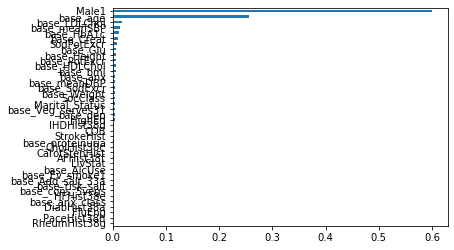

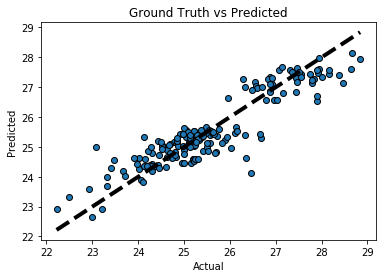

Mean squared error: 0.32
Test Variance score: 0.83
Test data R-2 score: 0.827
Test data Spearman correlation: 0.855
Test data Pearson correlation: 0.911


In [12]:
model_ranks=pd.Series(model.feature_importances_,index=x_training_set.columns,name="Importance").sort_values(ascending=True,inplace=False) 
ax=model_ranks.plot(kind='barh')

model_score = model.score(x_training_set,y_training_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('coefficient of determination R^2 of the prediction.: ',model_score)
y_predicted = model.predict(x_test_set)


#plot observed vs predicted
fig, ax = plt.subplots()
ax.scatter(y_test_set, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

#Model parameters study :
#The coefficient R^2 is defined as (1 – u/v), where u is the residual sum of squares ((y_true – y_pred) ** 2).sum() and v is the total sum of squares ((y_true – y_true.mean()) ** 2).sum(). 

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test_set, y_predicted))

# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test_set, y_predicted))


test_score = r2_score(y_test_set, y_predicted)
spearman = spearmanr(y_test_set, y_predicted)
pearson = pearsonr(y_test_set, y_predicted)

#print(f'Out-of-bag R-2 score estimate: {model.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [13]:
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
#https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
#calculate shapley values
#https://github.com/slundberg/shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_training_set)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [14]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_training_set.iloc[0,:])

In [15]:
shap.force_plot(explainer.expected_value, shap_values, x_training_set)

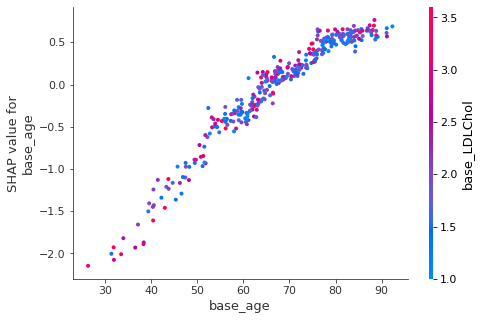

In [16]:
#partial dependency plot shows the marginal effect one or two features have on the predicted outcome 
#the plot show positive relationship with male sex
shap.dependence_plot("base_age", shap_values, x_training_set)

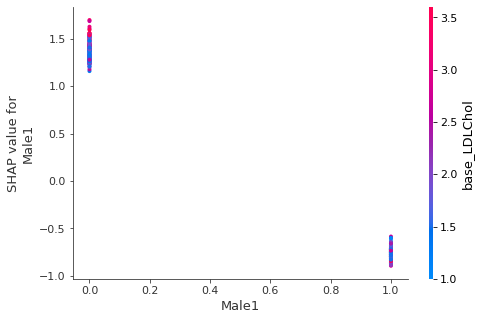

In [17]:
shap.dependence_plot("Male1", shap_values, x_training_set)

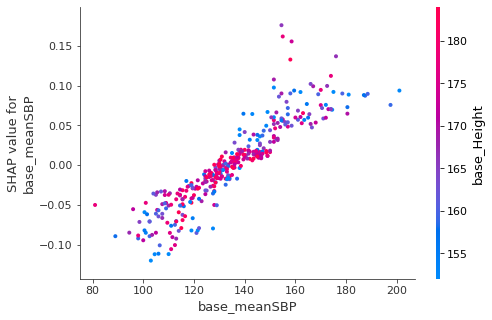

In [18]:
shap.dependence_plot("base_meanSBP", shap_values, x_training_set)

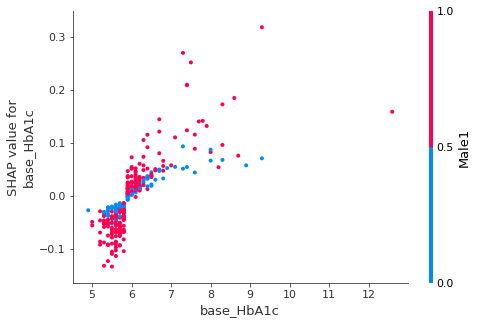

In [19]:
shap.dependence_plot("base_HbA1c", shap_values, x_training_set)

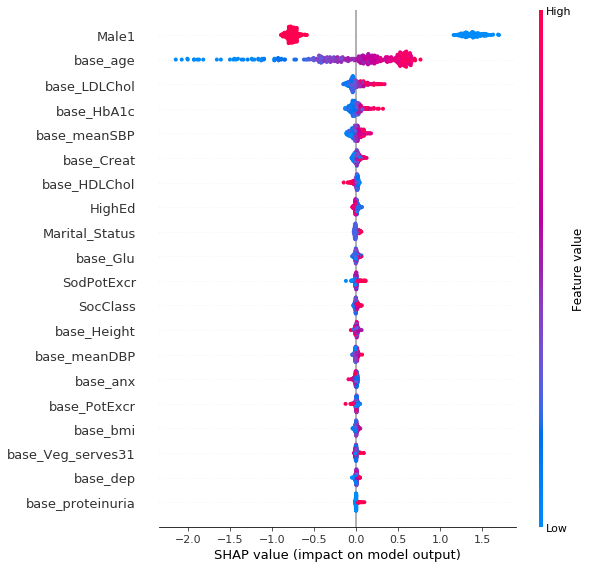

In [20]:
#positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, x_training_set)

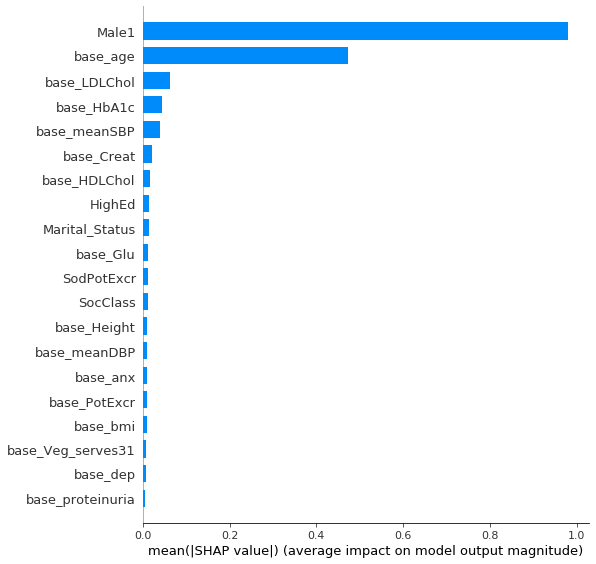

In [21]:
shap.summary_plot(shap_values, x_training_set, plot_type="bar")

In [22]:
#test data
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# model is the output of random forest regression
predictions = model.predict(x_test_set)
# Calculate the absolute errors
errors = abs(predictions - y_test_set)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.43 degrees.


In [23]:
# Calculate mean absolute percentage error 
mape = 100 * (errors / y_test_set)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.32 %.


In [24]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = model.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', 
                feature_names = x_training_set.columns, 
                rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')
#write as svg
graph.write_svg('tree.svg')

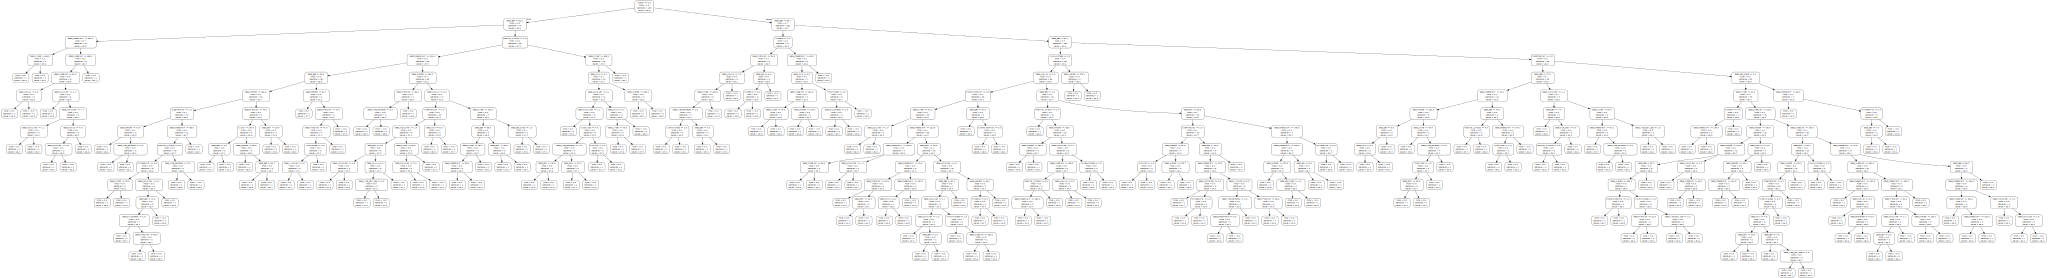

In [32]:
from IPython.display import SVG
def show_svg():
    return SVG('tree.svg')
show_svg()

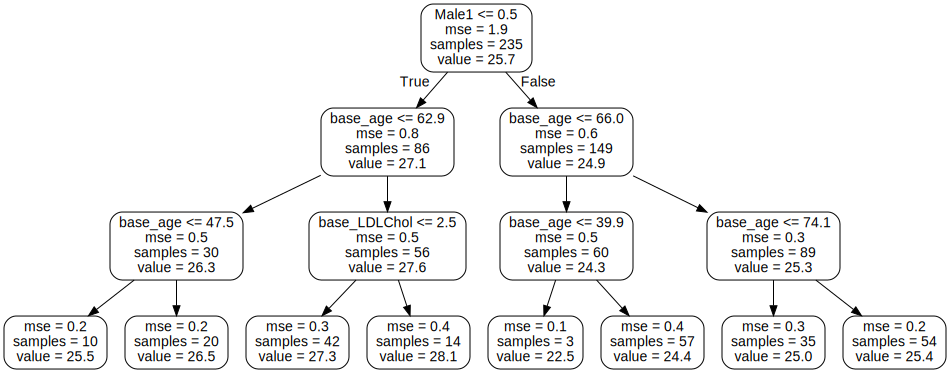

In [33]:
# Limit depth of tree to 3 levels
model_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
model_small.fit(x_training_set, y_training_set)
# Extract the small tree
tree_small = model_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', 
                feature_names=x_training_set.columns,
                rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');
graph.write_svg('small_tree.svg');
def show_svg():
    return SVG('small_tree.svg')
show_svg()